# 학습 목표
1. 구조 기반 가상 스크리닝(SBVS)을 학습한다
2. 딥러닝 기반 단백질-리간드 상호작용 예측 모델 구현하기
3. ChemBERTa와 ProtBERT를 활용한 AI 약물 개발 모델 구현하기

# 1. 구조 기반 가상 스크리닝 개요
- 구조 기반 가상 스크리닝(Structure-Based Virtual Screening, SBVS)은 단백질 표적의 3D 구조를 기반으로 활성 화합물을 발견하는 방법입니다.
- 주요 접근 방법:
  - 분자 도킹(Molecular Docking): 단백질 결합 부위에 화합물이 어떻게 결합하는지 시뮬레이션
  - 약리적 유사성 검색(Pharmacophore Screening): 생물학적 활성에 중요한 화합물의 3D 특성을 기반으로 검색
  - 구조 기반 딥러닝(Structure-Based Deep Learning): 단백질-리간드 복합체 구조의 특성을 학습하여 활성 예측

Lee, J., Jun, D. W., Song, I., & Kim, Y. (2024). DLM-DTI: a dual language model for the prediction of drug-target interaction with hint-based learning. Journal of Cheminformatics, 16(1), 14.

https://jcheminf.biomedcentral.com/articles/10.1186/s13321-024-00808-1

<img src='https://media.springernature.com/lw685/springer-static/image/art%3A10.1186%2Fs13321-024-00808-1/MediaObjects/13321_2024_808_Fig2_HTML.png'>

# 2. BindingDB 데이터 준비(이전 강의 자료)

In [ ]:
# 필요 라이브러리 설치
!pip install biopandas py3Dmol rdkit

!wget https://www.bindingdb.org/rwd/bind/downloads/BindingDB_BindingDB_Articles_2D_202503_sdf.zip

import os
import zipfile

zip_path = "BindingDB_BindingDB_Articles_2D_202503_sdf.zip"

# 압축 해제할 디렉토리
extract_dir = "bindingdb_data"

# 디렉토리가 없으면 생성
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

# 압축 해제
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

import pandas as pd
import numpy as np
from rdkit import Chem

def process_sdf_file(sdf_path):
    compounds = []
    suppl = Chem.SDMolSupplier(sdf_path)

    for mol in suppl:
        if mol is None:
            continue

        # 분자 속성 추출
        prop_dict = {}

        # 기본 속성 추출
        for prop_name in mol.GetPropNames():
            prop_dict[prop_name] = mol.GetProp(prop_name)

        # SMILES 생성
        prop_dict['SMILES'] = Chem.MolToSmiles(mol)

        compounds.append(prop_dict)

    return compounds

# 압축 해제된 SDF 파일 경로
sdf_file = os.path.join('bindingdb_data/BindingDB_BindingDB_Articles_2D.sdf')

# SDF 처리
compounds_data = process_sdf_file(sdf_file)

# 데이터프레임 생성
df = pd.DataFrame(compounds_data)

# 컬럼 선택
required_columns = ['BindingDB MonomerID', 'BindingDB Ligand Name', 'SMILES',
                   'BindingDB Target Chain Sequence', 'PDB ID(s) of Target Chain',
                   'Ki (nM)', 'IC50 (nM)', 'Kd (nM)', 'EC50 (nM)', 'Target Name']

# 존재하는 컬럼만 선택
available_columns = [col for col in required_columns if col in df.columns]
df_final = df[available_columns]

# 결과 확인
print(f"데이터프레임 크기: {df_final.shape}")
print(f"사용 가능한 컬럼: {df_final.columns.tolist()}")

df_final.head()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.3/68.3 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 15.8 MB/s eta 0:00:00
--2025-03-29 17:39:46--  https://www.bindingdb.org/rwd/bind/downloads/BindingDB_BindingDB_Articles_2D_202503_sdf.zip
Resolving www.bindingdb.org (www.bindingdb.org)... 132.239.186.19
Connecting to www.bindingdb.org (www.bindingdb.org)|132.239.186.19|:443... connected.
HTTP request sent, awaiting response... 200 
Length: 37104817 (35M) [application/zip]
Saving to: ‘BindingDB_BindingDB_Articles_2D_202503_sdf.zip’

BindingDB_BindingDB 100%[===================>]  35.39M  12.8MB/s    in 2.8s    

2025-03-29 17:39:49 (12.8 MB/s) - ‘BindingDB_BindingDB_Articles_2D_202503_sdf.zip’ saved [37104817/37104817]



[17:39:55] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26
[17:39:55] ERROR: Could not sanitize molecule ending on line 15956
[17:39:55] ERROR: Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26
[17:39:55] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 51 ignored
[17:39:55] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 50 ignored
[17:39:55] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 50 ignored
[17:39:55] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 50 ignored
[17:40:36] Explicit valence for atom # 27 N, 4, is greater than permitted
[17:40:36] ERROR: Could not sanitize molecule ending on line 8249825
[17:40:36] ERROR: Explicit valence for atom # 27 N, 4, is greater than permitted
[17:40:36] Explicit valence for atom # 27 N, 4, is greater than permitted
[17:40:36] ERROR: Could not sanitize molecule ending on line 8252267
[17:40:36] ERROR: Explicit valence for atom # 27 N,

데이터프레임 크기: (92852, 10)
사용 가능한 컬럼: ['BindingDB MonomerID', 'BindingDB Ligand Name', 'SMILES', 'BindingDB Target Chain Sequence', 'PDB ID(s) of Target Chain', 'Ki (nM)', 'IC50 (nM)', 'Kd (nM)', 'EC50 (nM)', 'Target Name']


,BindingDB MonomerID,BindingDB Ligand Name,SMILES,BindingDB Target Chain Sequence,PDB ID(s) of Target Chain,Ki (nM),IC50 (nM),Kd (nM),EC50 (nM),Target Name
0,4521,3-quinolinecarbonitrile 3::4-Phenylamino-3-qui...,COc1cc2c(Nc3ccc(Cl)cc3Cl)c(C#N)cnc2cc1OCCCN1CC...,MGSNKSKPKDASQRRRSLEPAENVHGAGGGAFPASQTPSKPASADG...,"1FMK,1HCS,1HCT,1O41,1O42,1O43,1O44,1O45,1O46,1...",,8.7,,,Proto-oncogene tyrosine-protein kinase Src
1,6121,3-quinolinecarbonitrile 4::6-methoxy-7-[3-(4-m...,COc1cc2c(Nc3cc(OC)c(OC)c(OC)c3)c(C#N)cnc2cc1OC...,MGSNKSKPKDASQRRRSLEPAENVHGAGGGAFPASQTPSKPASADG...,"1FMK,1HCS,1HCT,1O41,1O42,1O43,1O44,1O45,1O46,1...",,5.1,,,Proto-oncogene tyrosine-protein kinase Src
2,6122,"3-quinolinecarbonitrile 8::4-[(2,4-dichloro-5-...",COCCOc1cc2ncc(C#N)c(Nc3cc(OC)c(Cl)cc3Cl)c2cc1O...,MGSNKSKPKDASQRRRSLEPAENVHGAGGGAFPASQTPSKPASADG...,"1FMK,1HCS,1HCT,1O41,1O42,1O43,1O44,1O45,1O46,1...",,2.8,,,Proto-oncogene tyrosine-protein kinase Src
3,6123,"3-quinolinecarbonitrile 9::4-[(2,4-dichlorophe...",COCCOc1cc2ncc(C#N)c(Nc3ccc(Cl)cc3Cl)c2cc1OCCOC,MGSNKSKPKDASQRRRSLEPAENVHGAGGGAFPASQTPSKPASADG...,"1FMK,1HCS,1HCT,1O41,1O42,1O43,1O44,1O45,1O46,1...",,12,,,Proto-oncogene tyrosine-protein kinase Src
4,6124,"3-quinolinecarbonitrile 10::6,7-bis(2-methoxye...",COCCOc1cc2ncc(C#N)c(Nc3cc(OC)c(OC)c(OC)c3)c2cc...,MGSNKSKPKDASQRRRSLEPAENVHGAGGGAFPASQTPSKPASADG...,"1FMK,1HCS,1HCT,1O41,1O42,1O43,1O44,1O45,1O46,1...",,25,,,Proto-oncogene tyrosine-protein kinase Src


# 3. 데이터 일부 추출 및 활성 화합물 정의

In [ ]:
# 200개 샘플 추출
df_sample = df_final.sample(n=min(200, len(df_final)), random_state=42)

# 결측치 확인 및 처리
print("\n결측치 현황:")
print(df_sample.isnull().sum())

# 결측치 처리
numeric_cols = ['Ki (nM)', 'IC50 (nM)', 'Kd (nM)', 'EC50 (nM)']
for col in numeric_cols:
    if col in df_sample.columns:
        # 숫자형으로 변환 시도
        df_sample[col] = pd.to_numeric(df_sample[col], errors='coerce')
        # 결측치 처리
        df_sample[col] = df_sample[col].fillna(df_sample[col].median())

# SMILES 및 단백질 서열 유효성 확인
valid_smiles = []
for smiles in df_sample['SMILES'].values:
    mol = Chem.MolFromSmiles(smiles)
    valid_smiles.append(mol is not None)

print(f"유효한 SMILES 비율: {sum(valid_smiles) / len(valid_smiles):.2%}")

# 단백질 서열 유효성 검사 (기본적인 아미노산 문자만 포함하는지)
valid_proteins = []
protein_col = 'BindingDB Target Chain Sequence'
if protein_col in df_sample.columns:
    amino_acids = set('ACDEFGHIKLMNPQRSTVWY')
    for seq in df_sample[protein_col].values:
        if isinstance(seq, str):
            valid_proteins.append(all(aa in amino_acids for aa in seq))
        else:
            valid_proteins.append(False)
    print(f"유효한 단백질 서열 비율: {sum(valid_proteins) / len(valid_proteins):.2%}")

# 활성 지표 정의 (예: IC50 100nM 이하를 활성으로 판단)
if 'IC50 (nM)' in df_sample.columns:
    df_sample['Active'] = (df_sample['IC50 (nM)'] <= 100).astype(int)
    print(f"\n활성 화합물 비율: {df_sample['Active'].mean():.2%}")

df_sample.head()


결측치 현황:
BindingDB MonomerID                0
BindingDB Ligand Name              0
SMILES                             0
BindingDB Target Chain Sequence    0
PDB ID(s) of Target Chain          0
Ki (nM)                            0
IC50 (nM)                          0
Kd (nM)                            0
EC50 (nM)                          0
Target Name                        0
dtype: int64
유효한 SMILES 비율: 100.00%
유효한 단백질 서열 비율: 74.50%

활성 화합물 비율: 19.00%


,BindingDB MonomerID,BindingDB Ligand Name,SMILES,BindingDB Target Chain Sequence,PDB ID(s) of Target Chain,Ki (nM),IC50 (nM),Kd (nM),EC50 (nM),Target Name,Active
7108,4443,"4-(3-Bromophenylamino)-6,7-diethoxyquinoline-3...",CCOc1cc2ncc(C#N)c(Nc3cccc(Br)c3)c2cc1OCC,MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFED...,"1IVO,1M14,1M17,1MOX,1XKK,1Z9I,2GS2,2GS6,2ITW,2...",440.0,420.0,120.0,142.5,Epidermal growth factor receptor,0
22260,10882,"6-ethoxy-1,3-benzothiazole-2-sulfonamide::CHEM...",CCOc1ccc2nc(S(N)(=O)=O)sc2c1,MAPLCPSPWLPLLIPAPAPGLTVQLLLSLLLLVPVHPQRLPRMQED...,6Y74,34.0,659.5,120.0,142.5,Carbonic anhydrase 9,0
38003,20959,"2-Aryloxy-4-alkoxy-pyridine, 40::2-[4-(methoxy...",CCC(CC)Oc1cc(C)nc(Oc2c(C)cc(COC)cc2C)c1C,MGRRPQLRLVKALLLLGLNPVSTSLQDQRCENLSLTSNVSGLQCNA...,,440.0,3.2,120.0,142.5,Corticotropin-releasing factor receptor 1,1
67091,50298309,CHEMBL574533::ETP-7146::N-(3-methoxyphenyl)-1-...,COc1cccc(Nc2nc(N3CCN(C)CC3)nc3c2cnn3C)c1,MPPRPSSGELWGIHLMPPRILVECLLPNGMIVTLECLREATLITIK...,"2ENQ,2RD0,2V1Y,3ZIM,4L1B,4L23,4L2Y,4OVU,4OVV,4...",440.0,9200.0,120.0,142.5,"Phosphatidylinositol 4,5-bisphosphate 3-kinase...",0
39246,21523,"N-[(2R,3R,4R,5S,6R)-5-{[(2S,3R,4S,5R,6R)-4-[(b...",CCCCNC(=S)N[C@H]1[C@@H](O)[C@@H](CO)O[C@@H](O[...,MAFSGSQAPYLSPAVPFSGTIQGGLQDGLQITVNGTVLSSSGTRFA...,"2EAK,2EAL,2ZHK,2ZHL,2ZHM,2ZHN,3LSD,3LSE,3NV1,3...",440.0,659.5,69000.0,142.5,Galectin-9,0


# 4. 데이터 전처리

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel

# ChemBERTa 및 ProtBERT 토크나이저 로드
chem_tokenizer = AutoTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
prot_tokenizer = AutoTokenizer.from_pretrained("Rostlab/prot_bert")

class DrugProteinDataset(Dataset):
    def __init__(self, dataframe, smiles_col='SMILES', protein_col='BindingDB Target Chain Sequence',
                 label_col='Active', chem_tokenizer=None, prot_tokenizer=None, max_len_chem=128, max_len_prot=512):
        self.dataframe = dataframe
        self.smiles = dataframe[smiles_col].values
        self.proteins = dataframe[protein_col].values if protein_col in dataframe.columns else [""] * len(dataframe)

        # 레이블이 있으면 사용, 없으면 더미 값 생성
        if label_col in dataframe.columns:
            self.labels = dataframe[label_col].values
        else:
            self.labels = np.zeros(len(dataframe))

        self.chem_tokenizer = chem_tokenizer
        self.prot_tokenizer = prot_tokenizer
        self.max_len_chem = max_len_chem
        self.max_len_prot = max_len_prot

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        smiles = str(self.smiles[idx])
        protein = str(self.proteins[idx])
        label = float(self.labels[idx])

        # SMILES 토큰화
        chem_inputs = self.chem_tokenizer(
            smiles,
            padding='max_length',
            truncation=True,
            max_length=self.max_len_chem,
            return_tensors='pt'
        )

        # 단백질 서열 토큰화
        prot_inputs = self.prot_tokenizer(
            " ".join(protein),  # ProtBERT는 아미노산 사이에 공백 필요
            padding='max_length',
            truncation=True,
            max_length=self.max_len_prot,
            return_tensors='pt'
        )

        return {
            'chem_input_ids': chem_inputs['input_ids'].squeeze(),
            'chem_attention_mask': chem_inputs['attention_mask'].squeeze(),
            'prot_input_ids': prot_inputs['input_ids'].squeeze(),
            'prot_attention_mask': prot_inputs['attention_mask'].squeeze(),
            'labels': torch.tensor(label, dtype=torch.float)
        }

# 데이터셋 생성
if 'SMILES' in df_sample.columns and 'BindingDB Target Chain Sequence' in df_sample.columns:
    # 활성 레이블이 없으면 IC50 기반으로 생성
    if 'Active' not in df_sample.columns and 'IC50 (nM)' in df_sample.columns:
        df_sample['Active'] = (df_sample['IC50 (nM)'] <= 100).astype(int)

    # 데이터셋 분할 (학습/검증/테스트)
    from sklearn.model_selection import train_test_split

    # 먼저 학습+검증 세트와 테스트 세트 분리
    train_val_df, test_df = train_test_split(df_sample, test_size=0.2, random_state=42)

    # 학습 세트와 검증 세트 분리
    train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=42)

    print(f"학습 세트: {len(train_df)}, 검증 세트: {len(val_df)}, 테스트 세트: {len(test_df)}")

    # 데이터셋 생성
    train_dataset = DrugProteinDataset(
        train_df,
        chem_tokenizer=chem_tokenizer,
        prot_tokenizer=prot_tokenizer
    )

    val_dataset = DrugProteinDataset(
        val_df,
        chem_tokenizer=chem_tokenizer,
        prot_tokenizer=prot_tokenizer
    )

    test_dataset = DrugProteinDataset(
        test_df,
        chem_tokenizer=chem_tokenizer,
        prot_tokenizer=prot_tokenizer
    )

    # 데이터로더 생성
    batch_size = 4
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # 첫 번째 배치 확인
    sample_batch = next(iter(train_loader))
    print("배치 샘플 키:", sample_batch.keys())
    for k, v in sample_batch.items():
        if isinstance(v, torch.Tensor):
            print(f"{k} 형태:", v.shape)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/166 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/501 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/9.43k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/3.21k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/361 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/81.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

학습 세트: 128, 검증 세트: 32, 테스트 세트: 40
배치 샘플 키: dict_keys(['chem_input_ids', 'chem_attention_mask', 'prot_input_ids', 'prot_attention_mask', 'labels'])
chem_input_ids 형태: torch.Size([4, 128])
chem_attention_mask 형태: torch.Size([4, 128])
prot_input_ids 형태: torch.Size([4, 512])
prot_attention_mask 형태: torch.Size([4, 512])
labels 형태: torch.Size([4])


# 5. ChemBERTa-ProtBERT 모델 정의

In [ ]:
class DrugProteinInteractionModel(torch.nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(DrugProteinInteractionModel, self).__init__()

        # ChemBERTa 모델 로드
        self.chem_encoder = AutoModel.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")

        # ProtBERT 모델 로드
        self.prot_encoder = AutoModel.from_pretrained("Rostlab/prot_bert")

        # 각 인코더의 출력 크기 확인
        self.chem_hidden_size = self.chem_encoder.config.hidden_size  # 768
        self.prot_hidden_size = self.prot_encoder.config.hidden_size  # 1024

        # CLS 토큰 추출 후 결합하여 처리할 예측 헤드
        combined_hidden_size = self.chem_hidden_size + self.prot_hidden_size

        # 예측 헤드
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(combined_hidden_size, 512),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout_rate),
            torch.nn.Linear(512, 256),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout_rate),
            torch.nn.Linear(256, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 1),
            torch.nn.Sigmoid()
        )

    def forward(self, chem_input_ids, chem_attention_mask, prot_input_ids, prot_attention_mask):
        # 화합물 인코딩
        chem_outputs = self.chem_encoder(
            input_ids=chem_input_ids,
            attention_mask=chem_attention_mask,
            return_dict=True
        )

        # 단백질 인코딩
        prot_outputs = self.prot_encoder(
            input_ids=prot_input_ids,
            attention_mask=prot_attention_mask,
            return_dict=True
        )

        # [CLS] 토큰 임베딩 추출 (첫 번째 토큰 표현)
        chem_cls = chem_outputs.last_hidden_state[:, 0, :]  # (batch_size, chem_hidden_size)
        prot_cls = prot_outputs.last_hidden_state[:, 0, :]  # (batch_size, prot_hidden_size)

        # 결합
        combined = torch.cat([chem_cls, prot_cls], dim=1)  # (batch_size, chem_hidden_size + prot_hidden_size)

        # 분류/예측
        output = self.classifier(combined)

        return output

# 6. 모델 학습 및 평가

In [ ]:
# 학습 함수
def train_model(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=5):
    model.to(device)
    best_val_loss = float('inf')
    history = {'train_loss': [], 'val_loss': [], 'train_auc': [], 'val_auc': []}

    from sklearn.metrics import roc_auc_score

    for epoch in range(num_epochs):
        # 학습 모드
        model.train()
        train_loss = 0
        train_preds = []
        train_labels = []

        for batch in train_loader:
            # 배치 데이터 디바이스로 이동
            chem_input_ids = batch['chem_input_ids'].to(device)
            chem_attention_mask = batch['chem_attention_mask'].to(device)
            prot_input_ids = batch['prot_input_ids'].to(device)
            prot_attention_mask = batch['prot_attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # 그래디언트 초기화
            optimizer.zero_grad()

            # 순전파
            outputs = model(
                chem_input_ids=chem_input_ids,
                chem_attention_mask=chem_attention_mask,
                prot_input_ids=prot_input_ids,
                prot_attention_mask=prot_attention_mask
            )

            # 손실 계산
            loss = criterion(outputs.squeeze(), labels)

            # 역전파 및 옵티마이저 스텝
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # 예측값 및 레이블 저장 (AUC 계산용)
            train_preds.extend(outputs.squeeze().detach().cpu().numpy())
            train_labels.extend(labels.detach().cpu().numpy())

        # 에폭당 평균 손실
        train_loss /= len(train_loader)

        # 검증 모드
        model.eval()
        val_loss = 0
        val_preds = []
        val_labels = []

        with torch.no_grad():
            for batch in val_loader:
                chem_input_ids = batch['chem_input_ids'].to(device)
                chem_attention_mask = batch['chem_attention_mask'].to(device)
                prot_input_ids = batch['prot_input_ids'].to(device)
                prot_attention_mask = batch['prot_attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(
                    chem_input_ids=chem_input_ids,
                    chem_attention_mask=chem_attention_mask,
                    prot_input_ids=prot_input_ids,
                    prot_attention_mask=prot_attention_mask
                )

                loss = criterion(outputs.squeeze(), labels)
                val_loss += loss.item()

                val_preds.extend(outputs.squeeze().detach().cpu().numpy())
                val_labels.extend(labels.detach().cpu().numpy())

        val_loss /= len(val_loader)

        # AUC 계산
        try:
            train_auc = roc_auc_score(train_labels, train_preds)
            val_auc = roc_auc_score(val_labels, val_preds)
        except:
            train_auc = 0
            val_auc = 0

        # 기록 저장
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_auc'].append(train_auc)
        history['val_auc'].append(val_auc)

        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train loss: {train_loss:.4f}, Train AUC: {train_auc:.4f}, "
              f"Val loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}")

        # 최상의 모델 저장
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_drug_protein_model.pt')

    return history, model

# 평가 함수
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            chem_input_ids = batch['chem_input_ids'].to(device)
            chem_attention_mask = batch['chem_attention_mask'].to(device)
            prot_input_ids = batch['prot_input_ids'].to(device)
            prot_attention_mask = batch['prot_attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                chem_input_ids=chem_input_ids,
                chem_attention_mask=chem_attention_mask,
                prot_input_ids=prot_input_ids,
                prot_attention_mask=prot_attention_mask
            )

            loss = criterion(outputs.squeeze(), labels)
            test_loss += loss.item()

            all_preds.extend(outputs.squeeze().detach().cpu().numpy())
            all_labels.extend(labels.detach().cpu().numpy())

    test_loss /= len(test_loader)

    # 평가 지표 계산
    from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

    # 이진 레이블로 변환 (0.5 임계값)
    binary_preds = [1 if p >= 0.5 else 0 for p in all_preds]

    metrics = {
        'loss': test_loss,
        'accuracy': accuracy_score(all_labels, binary_preds),
        'precision': precision_score(all_labels, binary_preds, zero_division=0),
        'recall': recall_score(all_labels, binary_preds, zero_division=0),
        'f1': f1_score(all_labels, binary_preds, zero_division=0),
        'roc_auc': roc_auc_score(all_labels, all_preds)
    }

    # PR-AUC 계산
    precision, recall, _ = precision_recall_curve(all_labels, all_preds)
    metrics['pr_auc'] = auc(recall, precision)

    return metrics, all_preds, all_labels

In [ ]:
import torch

# 모델 초기화
model = DrugProteinInteractionModel(dropout_rate=0.3)

# 학습 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = torch.nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

# 학습 실행
num_epochs = 3
history, trained_model = train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    device,
    num_epochs=num_epochs
)

pytorch_model.bin:   0%|          | 0.00/179M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/179M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

Epoch 1/3 - Train loss: 0.6624, Train AUC: 0.4686, Val loss: 0.6105, Val AUC: 0.4744
Epoch 2/3 - Train loss: 0.6052, Train AUC: 0.4411, Val loss: 0.5435, Val AUC: 0.5385
Epoch 3/3 - Train loss: 0.5437, Train AUC: 0.6518, Val loss: 0.5030, Val AUC: 0.5641


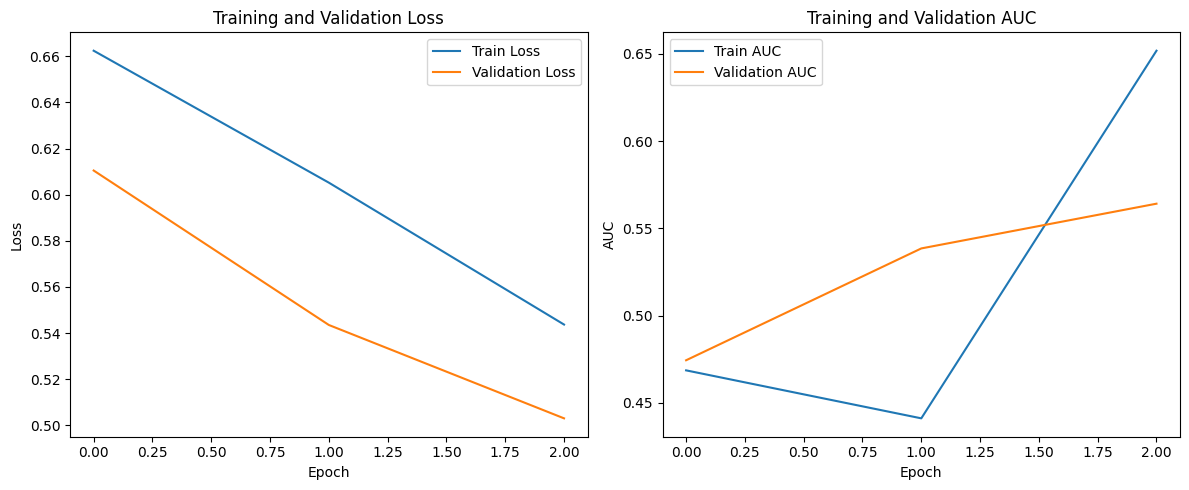


테스트 데이터 평가 중...

테스트 결과:
loss: 0.4188
accuracy: 0.9000
precision: 0.0000
recall: 0.0000
f1: 0.0000
roc_auc: 0.5694
pr_auc: 0.1433


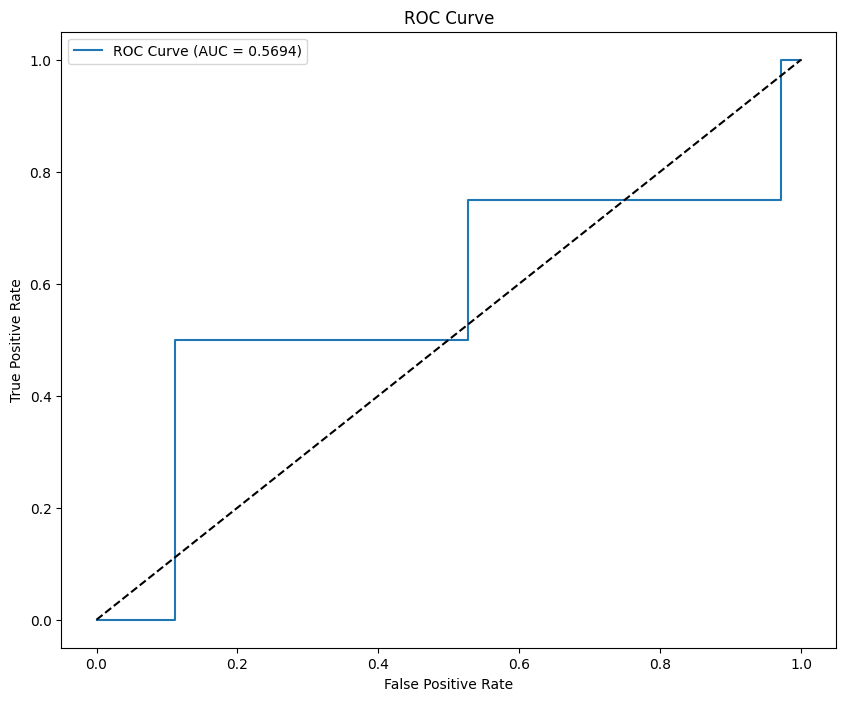

In [ ]:
import matplotlib.pyplot as plt

 # 학습 곡선 시각화
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history['train_auc'], label='Train AUC')
plt.plot(history['val_auc'], label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.title('Training and Validation AUC')

plt.tight_layout()
plt.show()

# 테스트 데이터로 평가
print("\n테스트 데이터 평가 중...")
metrics, test_preds, test_labels = evaluate_model(trained_model, test_loader, criterion, device)

# 결과 출력
print("\n테스트 결과:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

# ROC 곡선 시각화
from sklearn.metrics import roc_curve

plt.figure(figsize=(10, 8))
fpr, tpr, _ = roc_curve(test_labels, test_preds)
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {metrics['roc_auc']:.4f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()